# Some Additional Generative Models

## Diffusion Models

**1. Forward Diffusion Process (Markov Chain)**

Diffusion models generate data by gradually adding noise to an initial data sample $ x_0 $ over $ T $ discrete timesteps, following a *Markovian process*:

$$
q(x_t \mid x_{t-1}) = \mathcal{N} (x_t ; \sqrt{(1 - \beta_t)} x_{t-1}, \beta_t I)
$$

where:
- $ x_0 $ is the original data sample (e.g., an image).
- $ x_t $ is the noisy version at timestep $ t $.
- $ \beta_t $ is the variance schedule, which determines the amount of noise added at each step.
- $ \mathcal{N} $ represents a Gaussian distribution.

Using reparameterization, we can express $ x_t $ directly in terms of $ x_0 $:

$$
x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon, \quad \epsilon \sim \mathcal{N}(0, I)
$$

where:

$$
\bar{\alpha}_t = \prod_{s=1}^{t} (1 - \beta_s)
$$

represents the cumulative effect of noise over time.

**2. Reverse Diffusion Process (Generative Model)**
The goal of the model is to learn the reverse process, removing noise step by step to recover $ x_0 $. The reverse transition is also Gaussian:

$$
p_\theta(x_{t-1} \mid x_t) = \mathcal{N}(x_{t-1}; \mu_\theta(x_t, t), \Sigma_\theta(x_t, t))
$$

where:
- $ \mu_\theta(x_t, t) $ is the predicted mean by a neural network.
- $ \Sigma_\theta(x_t, t) $ is the variance, which can be learned or fixed.
- $ \theta $ represents the trainable parameters of the model.

A common approach is to parameterize the mean function using a neural network that predicts noise $ \epsilon_\theta(x_t, t) $:

$$
\mu_\theta(x_t, t) = \frac{1}{\sqrt{(1 - \beta_t)}} \left(x_t - \frac{\beta_t}{\sqrt{1 - \bar{\alpha}_t}} \epsilon_\theta(x_t, t) \right)
$$

This allows us to train the model by minimizing the following loss function:

$$
L(\theta) = \mathbb{E}_{x_0, \epsilon, t} \left[ \|\epsilon - \epsilon_\theta(x_t, t)\|^2 \right]
$$

where:
- $ \epsilon $ is the true noise added in the forward process.
- $ \epsilon_\theta(x_t, t) $ is the neural network's predicted noise.

**3. Training & Sampling**

- Training: The model is trained by feeding noisy samples $ x_t $ into a neural network, which predicts $ \epsilon $.
- Sampling: Given pure noise $ x_T \sim \mathcal{N}(0, I) $, the model generates a sample by iteratively applying the reverse process:

$$
x_{t-1} = \mu_\theta(x_t, t) + \Sigma_\theta^{1/2}(x_t, t) \cdot z, \quad z \sim \mathcal{N}(0, I)
$$

until $ x_0 $ is obtained.

**4. Applications**

Diffusion models are widely used for:
- Image generation (e.g., DALL·E, Stable Diffusion).
- Text-to-image synthesis.
- Audio synthesis and speech generation.
- Molecular generation and scientific applications.

![diffusion](./images/am1.webp)

Epoch 1, Loss: 0.35681942105293274
Epoch 2, Loss: 0.09462916105985641
Epoch 3, Loss: 0.062662772834301
Epoch 4, Loss: 0.05894159898161888
Epoch 5, Loss: 0.30549156665802
Epoch 6, Loss: 0.03442605957388878
Epoch 7, Loss: 0.12080363184213638
Epoch 8, Loss: 0.04915479198098183
Epoch 9, Loss: 0.06945271044969559
Epoch 10, Loss: 0.10236871242523193
Epoch 11, Loss: 0.13123071193695068
Epoch 12, Loss: 0.18108341097831726
Epoch 13, Loss: 0.1694227010011673
Epoch 14, Loss: 0.07396028190851212
Epoch 15, Loss: 0.24840106070041656
Epoch 16, Loss: 0.08671264350414276
Epoch 17, Loss: 0.9405103325843811
Epoch 18, Loss: 1.4512217044830322
Epoch 19, Loss: 1.3934687376022339
Epoch 20, Loss: 0.04112812504172325
Epoch 21, Loss: 0.08887694776058197
Epoch 22, Loss: 0.47423186898231506
Epoch 23, Loss: 0.6319367289543152
Epoch 24, Loss: 0.2863155007362366
Epoch 25, Loss: 0.35295456647872925


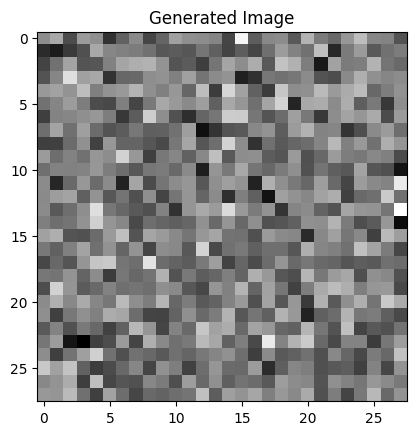

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Define parameters
T = 1000  # Number of diffusion steps
beta = torch.linspace(0.0001, 0.02, T)  # Noise schedule
alpha = 1 - beta
alpha_hat = torch.cumprod(alpha, dim=0)  # Cumulative product

# Function to add noise to an image
def forward_diffusion(x0, t):
    """ Applies forward diffusion by adding noise at time step t """
    noise = torch.randn_like(x0)
    sqrt_alpha_hat = torch.sqrt(alpha_hat[t])[:, None, None, None]
    sqrt_one_minus_alpha_hat = torch.sqrt(1 - alpha_hat[t])[:, None, None, None]
    xt = sqrt_alpha_hat * x0 + sqrt_one_minus_alpha_hat * noise
    return xt, noise

# Define a simple UNet-style model for denoising
class SimpleDenoiser(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=3, padding=1)
        )

    def forward(self, x, t):
        return self.net(x)

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleDenoiser().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# Dummy dataset (random noise as placeholder for images)
data = torch.randn(1000, 1, 28, 28).to(device)  # Simulating MNIST-like images

for epoch in range(25):  # Small number of epochs for simplicity
    for x0 in data:
        x0 = x0.unsqueeze(0)  # Add batch dimension
        t = torch.randint(0, T, (1,)).to(device)  # Random timestep
        xt, noise = forward_diffusion(x0, t)
        predicted_noise = model(xt, t)
        loss = loss_fn(predicted_noise, noise)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f"Epoch {epoch + 1}, Loss: {loss.item()}")

# Sampling process: start from pure noise
x_t = torch.randn(1, 1, 28, 28).to(device)  # Start from random noise
for t in reversed(range(T)):
    z = torch.randn_like(x_t) if t > 0 else torch.zeros_like(x_t)  # Add noise except last step
    predicted_noise = model(x_t, torch.tensor([t]).to(device))
    alpha_t = alpha[t]
    alpha_hat_t = alpha_hat[t]
    beta_t = beta[t]
    x_t = (1 / torch.sqrt(alpha_t)) * (x_t - (beta_t / torch.sqrt(1 - alpha_hat_t)) * predicted_noise) + torch.sqrt(beta_t) * z

# Convert to NumPy and plot
x_t = x_t.squeeze().cpu().detach().numpy()
plt.imshow(x_t, cmap="gray")
plt.title("Generated Image")
plt.show()

## Normalizing Flows

**1. Introduction**

Normalizing Flows (NFs) are a class of generative models that transform a simple probability distribution into a complex one using a sequence of invertible transformations. Given a latent variable $ z $ sampled from a simple distribution (e.g., Gaussian), the model applies a series of transformations to obtain a more complex data distribution.

$$
z_0 \sim p(z), \quad x = f_K \circ f_{K-1} \circ \dots \circ f_1 (z_0)
$$

where:
- $ z_0 $ is sampled from a base distribution $ p(z) $ (usually Gaussian).
- $ x $ is the transformed variable following a complex data distribution.
- Each $ f_i $ is an invertible transformation with a tractable Jacobian determinant.

**2. Change of Variables Formula**

Using the change of variables formula, the probability density of $ x $ is given by:

$$
p_X(x) = p_Z(z) \left| \det \frac{\partial f^{-1}(x)}{\partial x} \right|
$$

which can be rewritten using a sequence of transformations:

$$
p_X(x) = p_Z(z_0) \prod_{i=1}^{K} \left| \det \frac{\partial f_i^{-1}(z_i)}{\partial z_i} \right|
$$

where:

- $ p_Z(z_0) $ is the density of the simple prior distribution (e.g., Gaussian).
- $ f_i $ are the invertible transformations.
- The determinant term accounts for the volume change in transformation.

Taking the logarithm:

$$
\log p_X(x) = \log p_Z(z_0) + \sum_{i=1}^{K} \log \left| \det \frac{\partial f_i^{-1}(z_i)}{\partial z_i} \right|
$$

This allows us to compute likelihoods efficiently, making Normalizing Flows useful for density estimation.

**3. Training Objective**

To train a Normalizing Flow, we maximize the log-likelihood of data samples:

$$
\max_{\theta} \sum_{n} \log p_X(x_n; \theta)
$$

Since each transformation $ f_i $

Thus, the optimization process involves computing the log-likelihood and its gradients using backpropagation.

**4. Choice of Transformations**

For Normalizing Flows to be effective, the transformations $ f_i $ must be:
- Invertible: Ensuring that we can map between data and latent space.
- Efficiently Computable: The determinant of the Jacobian should be easy to compute.

Some popular transformations used in Normalizing Flows include:

- *Affine Coupling Layers (RealNVP)*: Splits input into two parts, transforms one part conditioned on the other.

  $$
  x_1' = x_1, \quad x_2' = x_2 \cdot e^{s(x_1)} + t(x_1)
  $$

  where $ s(x_1) $ and $ t(x_1) $ are scale and translation functions.

- *Planar Flow*: Adds a simple nonlinearity:

  $$
  f(z) = z + u h(w^T z + b)
  $$

  where $ h(\cdot) $ is a non-linear function.

- *Radial Flow*: Expands or contracts the space around a point $ z_0 $:

  $$
  f(z) = z + \beta (z - z_0) \frac{1}{\alpha + ||z - z_0||}
  $$

**5. Applications**

Normalizing Flows are widely used in:
- Density Estimation: Learning complex probability distributions.
- Variational Inference: Enhancing VAEs by improving posterior approximations.
- Generative Modeling: Sampling realistic images, audio, and text.

Epoch 0, Loss: 99.55941009521484
Epoch 200, Loss: 1.8463068008422852
Epoch 400, Loss: 1.5529121160507202
Epoch 600, Loss: 1.3037148714065552
Epoch 800, Loss: 1.2148408889770508
Epoch 1000, Loss: 1.2053309679031372
Epoch 1200, Loss: 1.198183298110962
Epoch 1400, Loss: 1.1717842817306519
Epoch 1600, Loss: 1.1199278831481934
Epoch 1800, Loss: 1.143525242805481


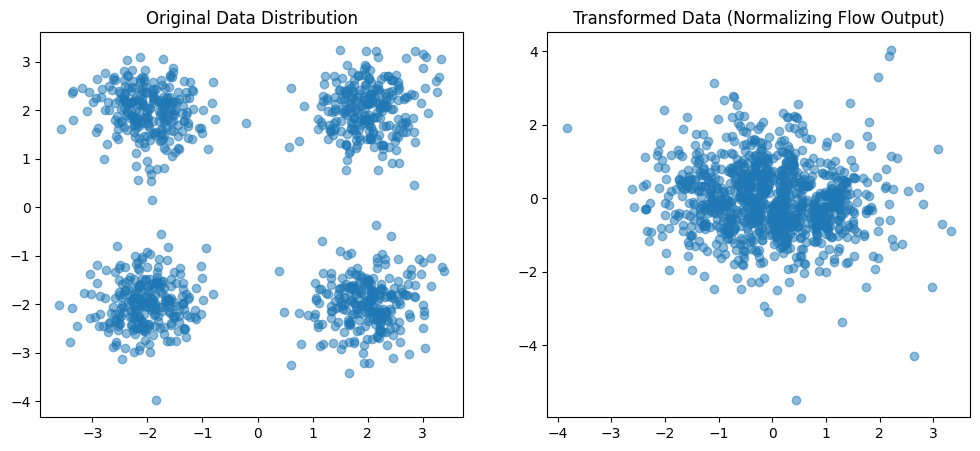

In [1]:
# pip install FrEIA
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import FrEIA.framework as Ff
import FrEIA.modules as Fm

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define dimensions
input_dim = 2  # 2D dataset for visualization

# Define a simple fully connected subnet
def subnet_fc(dims_in, dims_out):
    return nn.Sequential(
        nn.Linear(dims_in, 128),
        nn.ReLU(),
        nn.Linear(128, dims_out),
    )

# Define a simple Normalizing Flow using RealNVP blocks
nodes = [Ff.InputNode(input_dim, name="input")]
for i in range(6):  # Stack multiple RealNVP layers
    nodes.append(Ff.Node(nodes[-1], Fm.RNVPCouplingBlock, {"subnet_constructor": subnet_fc}, name=f"coupling_{i}"))
nodes.append(Ff.OutputNode(nodes[-1], name="output"))

# Create the normalizing flow model
flow = Ff.GraphINN(nodes).to(device)

# Define optimizer
optimizer = optim.Adam(flow.parameters(), lr=1e-3)

# Generate toy 2D data: a mixture of Gaussians
def sample_mixture(n=1000):
    centers = [(-2, -2), (2, 2), (-2, 2), (2, -2)]
    samples = np.concatenate([np.random.randn(n//4, 2) * 0.5 + np.array(center) for center in centers], axis=0)
    return torch.tensor(samples, dtype=torch.float32)

# Training loop
num_epochs = 2000
batch_size = 256
for epoch in range(num_epochs):
    # Sample data
    x_data = sample_mixture(batch_size).to(device)
    
    # Forward: compute log likelihood
    z, log_jac_det = flow(x_data)
    log_p_z = -0.5 * torch.sum(z**2, dim=1)  # Standard Gaussian log-probability
    loss = -torch.mean(log_p_z + log_jac_det)  # Negative log-likelihood

    # Backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 200 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

# Visualizing the learned transformation
with torch.no_grad():
    x_sample = sample_mixture(1000).to(device)
    z_transformed, _ = flow(x_sample)

    plt.figure(figsize=(12, 5))
    
    # Original Data
    plt.subplot(1, 2, 1)
    plt.scatter(x_sample[:, 0].cpu(), x_sample[:, 1].cpu(), alpha=0.5)
    plt.title("Original Data Distribution")
    
    # Transformed Data (Mapped to Gaussian)
    plt.subplot(1, 2, 2)
    plt.scatter(z_transformed[:, 0].cpu(), z_transformed[:, 1].cpu(), alpha=0.5)
    plt.title("Transformed Data (Normalizing Flow Output)")

    plt.show()

## Energy-Based Models

Energy-Based Models (EBMs) define probability distributions using an *energy function*, where lower energy values correspond to more likely configurations. These models are used in various applications, including image generation, structured prediction, and reinforcement learning.


**1. Energy Function and Probability Distribution**

An Energy-Based Model defines an energy function $ E(x) $, which assigns a scalar energy to each possible state $ x $. The probability distribution over $ x $ is then defined using the *Boltzmann distribution*:

$$
P(x) = \frac{e^{-E(x)}}{Z}
$$

where:

- $ E(x) $ is the energy function that assigns an energy value to each $ x $.
- $ Z $ is the *partition function*, ensuring normalization:

$$
Z = \sum_{x} e^{-E(x)}
$$

or, in the case of continuous variables:

$$
Z = \int e^{-E(x)} dx
$$

Computing $ Z $ is often intractable, making learning and inference challenging.


**2. Learning in Energy-Based Models**

The goal of training an EBM is to learn an energy function $ E(x) $ such that observed (real) data have lower energy values than unobserved (unlikely) data. We typically optimize parameters $ \theta $ of $ E(x; \theta) $ using *Maximum Likelihood Estimation (MLE)*.

The log-likelihood of the data is:

$$
\log P(x) = -E(x) - \log Z
$$

The gradient of the log-likelihood with respect to parameters $ \theta $ is:

$$
\nabla_\theta \log P(x) = -\nabla_\theta E(x) + \mathbb{E}_{x' \sim P(x')} [\nabla_\theta E(x')]
$$

where:

- The first term *lowers energy* for observed samples.
- The second term *raises energy* for unobserved samples.

This expectation is difficult to compute, requiring approximation methods like *Contrastive Divergence (CD)* or *Markov Chain Monte Carlo (MCMC) sampling*.

**3. Contrastive Divergence for Training**

One efficient way to approximate the gradient is *Contrastive Divergence (CD)*, which updates the energy function using a *Gibbs sampling* or *Langevin dynamics* process.

1. Start with a data sample $ x_0 $.
2. Run a Markov Chain to generate a new sample $ x_k $ using a transition operator $ T $, such as:

   $$
   x_{t+1} = x_t - \alpha \nabla_x E(x_t) + \eta
   $$

   where $ \eta \sim \mathcal{N}(0, \sigma^2) $ is Gaussian noise.
3. Update the model parameters using:

   $$
   \Delta \theta = -\nabla_\theta E(x_0) + \nabla_\theta E(x_k)
   $$



**4. Energy-Based Models vs. Other Generative Models**
| Model Type         | Probability Distribution | Learning Challenge |
|--------------------|------------------------|--------------------|
| EBMs              | Implicitly defined with $ E(x) $ | Requires sampling for training |
| GANs              | No explicit density, uses discriminator | Training instability |
| VAEs              | Uses explicit likelihood with latent variables | Variational approximation required |


**5. Applications of EBMs**
- Image Generation: Training energy functions on images (e.g., Deep Energy-Based Models).
- Reinforcement Learning: Modeling value functions in a probabilistic manner.
- Anomaly Detection: Identifying samples with high energy values.


In [6]:
## Standard libraries
import os
import json
import math
import numpy as np
import random

## Imports for plotting
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
from mpl_toolkits.mplot3d.axes3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
# PyTorch Lightning
import pytorch_lightning as pl

from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial8"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial8/"
# Files to download
pretrained_files = ["MNIST.ckpt", "tensorboards/events.out.tfevents.MNIST"]

# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if "/" in file_name:
        os.makedirs(file_path.rsplit("/",1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)


# Transformations applied on each image => make them a tensor and normalize between -1 and 1
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
                               ])

# Loading the training dataset. We need to split it into a training and validation part
train_set = MNIST(root=DATASET_PATH, train=True, transform=transform, download=True)

# Loading the test set
test_set = MNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
# Note that for actually training a model, we will use different data loaders
# with a lower batch size.
train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True,  drop_last=True,  num_workers=4, pin_memory=True)
test_loader  = data.DataLoader(test_set,  batch_size=256, shuffle=False, drop_last=False, num_workers=4)


class Swish(nn.Module):

    def forward(self, x):
        return x * torch.sigmoid(x)


class CNNModel(nn.Module):

    def __init__(self, hidden_features=32, out_dim=1, **kwargs):
        super().__init__()
        # We increase the hidden dimension over layers. Here pre-calculated for simplicity.
        c_hid1 = hidden_features//2
        c_hid2 = hidden_features
        c_hid3 = hidden_features*2

        # Series of convolutions and Swish activation functions
        self.cnn_layers = nn.Sequential(
                nn.Conv2d(1, c_hid1, kernel_size=5, stride=2, padding=4), # [16x16] - Larger padding to get 32x32 image
                Swish(),
                nn.Conv2d(c_hid1, c_hid2, kernel_size=3, stride=2, padding=1), #  [8x8]
                Swish(),
                nn.Conv2d(c_hid2, c_hid3, kernel_size=3, stride=2, padding=1), # [4x4]
                Swish(),
                nn.Conv2d(c_hid3, c_hid3, kernel_size=3, stride=2, padding=1), # [2x2]
                Swish(),
                nn.Flatten(),
                nn.Linear(c_hid3*4, c_hid3),
                Swish(),
                nn.Linear(c_hid3, out_dim)
        )

    def forward(self, x):
        x = self.cnn_layers(x).squeeze(dim=-1)
        return x
    
class Sampler:

    def __init__(self, model, img_shape, sample_size, max_len=8192):
        """
        Inputs:
            model - Neural network to use for modeling E_theta
            img_shape - Shape of the images to model
            sample_size - Batch size of the samples
            max_len - Maximum number of data points to keep in the buffer
        """
        super().__init__()
        self.model = model
        self.img_shape = img_shape
        self.sample_size = sample_size
        self.max_len = max_len
        self.examples = [(torch.rand((1,)+img_shape)*2-1) for _ in range(self.sample_size)]

    def sample_new_exmps(self, steps=60, step_size=10):
        """
        Function for getting a new batch of "fake" images.
        Inputs:
            steps - Number of iterations in the MCMC algorithm
            step_size - Learning rate nu in the algorithm above
        """
        # Choose 95% of the batch from the buffer, 5% generate from scratch
        n_new = np.random.binomial(self.sample_size, 0.05)
        rand_imgs = torch.rand((n_new,) + self.img_shape) * 2 - 1
        old_imgs = torch.cat(random.choices(self.examples, k=self.sample_size-n_new), dim=0)
        inp_imgs = torch.cat([rand_imgs, old_imgs], dim=0).detach().to(device)

        # Perform MCMC sampling
        inp_imgs = Sampler.generate_samples(self.model, inp_imgs, steps=steps, step_size=step_size)

        # Add new images to the buffer and remove old ones if needed
        self.examples = list(inp_imgs.to(torch.device("cpu")).chunk(self.sample_size, dim=0)) + self.examples
        self.examples = self.examples[:self.max_len]
        return inp_imgs

    @staticmethod
    def generate_samples(model, inp_imgs, steps=60, step_size=10, return_img_per_step=False):
        """
        Function for sampling images for a given model.
        Inputs:
            model - Neural network to use for modeling E_theta
            inp_imgs - Images to start from for sampling. If you want to generate new images, enter noise between -1 and 1.
            steps - Number of iterations in the MCMC algorithm.
            step_size - Learning rate nu in the algorithm above
            return_img_per_step - If True, we return the sample at every iteration of the MCMC
        """
        # Before MCMC: set model parameters to "required_grad=False"
        # because we are only interested in the gradients of the input.
        is_training = model.training
        model.eval()
        for p in model.parameters():
            p.requires_grad = False
        inp_imgs.requires_grad = True

        # Enable gradient calculation if not already the case
        had_gradients_enabled = torch.is_grad_enabled()
        torch.set_grad_enabled(True)

        # We use a buffer tensor in which we generate noise each loop iteration.
        # More efficient than creating a new tensor every iteration.
        noise = torch.randn(inp_imgs.shape, device=inp_imgs.device)

        # List for storing generations at each step (for later analysis)
        imgs_per_step = []

        # Loop over K (steps)
        for _ in range(steps):
            # Part 1: Add noise to the input.
            noise.normal_(0, 0.005)
            inp_imgs.data.add_(noise.data)
            inp_imgs.data.clamp_(min=-1.0, max=1.0)

            # Part 2: calculate gradients for the current input.
            out_imgs = -model(inp_imgs)
            out_imgs.sum().backward()
            inp_imgs.grad.data.clamp_(-0.03, 0.03) # For stabilizing and preventing too high gradients

            # Apply gradients to our current samples
            inp_imgs.data.add_(-step_size * inp_imgs.grad.data)
            inp_imgs.grad.detach_()
            inp_imgs.grad.zero_()
            inp_imgs.data.clamp_(min=-1.0, max=1.0)

            if return_img_per_step:
                imgs_per_step.append(inp_imgs.clone().detach())

        # Reactivate gradients for parameters for training
        for p in model.parameters():
            p.requires_grad = True
        model.train(is_training)

        # Reset gradient calculation to setting before this function
        torch.set_grad_enabled(had_gradients_enabled)

        if return_img_per_step:
            return torch.stack(imgs_per_step, dim=0)
        else:
            return inp_imgs

class DeepEnergyModel(pl.LightningModule):

    def __init__(self, img_shape, batch_size, alpha=0.1, lr=1e-4, beta1=0.0, **CNN_args):
        super().__init__()
        self.save_hyperparameters()

        self.cnn = CNNModel(**CNN_args)
        self.sampler = Sampler(self.cnn, img_shape=img_shape, sample_size=batch_size)
        self.example_input_array = torch.zeros(1, *img_shape)

    def forward(self, x):
        z = self.cnn(x)
        return z

    def configure_optimizers(self):
        # Energy models can have issues with momentum as the loss surfaces changes with its parameters.
        # Hence, we set it to 0 by default.
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.lr, betas=(self.hparams.beta1, 0.999))
        scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.97) # Exponential decay over epochs
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        # We add minimal noise to the original images to prevent the model from focusing on purely "clean" inputs
        real_imgs, _ = batch
        small_noise = torch.randn_like(real_imgs) * 0.005
        real_imgs.add_(small_noise).clamp_(min=-1.0, max=1.0)

        # Obtain samples
        fake_imgs = self.sampler.sample_new_exmps(steps=60, step_size=10)

        # Predict energy score for all images
        inp_imgs = torch.cat([real_imgs, fake_imgs], dim=0)
        real_out, fake_out = self.cnn(inp_imgs).chunk(2, dim=0)

        # Calculate losses
        reg_loss = self.hparams.alpha * (real_out ** 2 + fake_out ** 2).mean()
        cdiv_loss = fake_out.mean() - real_out.mean()
        loss = reg_loss + cdiv_loss

        # Logging
        self.log('loss', loss)
        self.log('loss_regularization', reg_loss)
        self.log('loss_contrastive_divergence', cdiv_loss)
        self.log('metrics_avg_real', real_out.mean())
        self.log('metrics_avg_fake', fake_out.mean())
        return loss

    def validation_step(self, batch, batch_idx):
        # For validating, we calculate the contrastive divergence between purely random images and unseen examples
        # Note that the validation/test step of energy-based models depends on what we are interested in the model
        real_imgs, _ = batch
        fake_imgs = torch.rand_like(real_imgs) * 2 - 1

        inp_imgs = torch.cat([real_imgs, fake_imgs], dim=0)
        real_out, fake_out = self.cnn(inp_imgs).chunk(2, dim=0)

        cdiv = fake_out.mean() - real_out.mean()
        self.log('val_contrastive_divergence', cdiv)
        self.log('val_fake_out', fake_out.mean())
        self.log('val_real_out', real_out.mean())

class GenerateCallback(pl.Callback):

    def __init__(self, batch_size=8, vis_steps=8, num_steps=256, every_n_epochs=5):
        super().__init__()
        self.batch_size = batch_size         # Number of images to generate
        self.vis_steps = vis_steps           # Number of steps within generation to visualize
        self.num_steps = num_steps           # Number of steps to take during generation
        self.every_n_epochs = every_n_epochs # Only save those images every N epochs (otherwise tensorboard gets quite large)

    def on_epoch_end(self, trainer, pl_module):
        # Skip for all other epochs
        if trainer.current_epoch % self.every_n_epochs == 0:
            # Generate images
            imgs_per_step = self.generate_imgs(pl_module)
            # Plot and add to tensorboard
            for i in range(imgs_per_step.shape[1]):
                step_size = self.num_steps // self.vis_steps
                imgs_to_plot = imgs_per_step[step_size-1::step_size,i]
                grid = torchvision.utils.make_grid(imgs_to_plot, nrow=imgs_to_plot.shape[0], normalize=True, range=(-1,1))
                trainer.logger.experiment.add_image(f"generation_{i}", grid, global_step=trainer.current_epoch)

    def generate_imgs(self, pl_module):
        pl_module.eval()
        start_imgs = torch.rand((self.batch_size,) + pl_module.hparams["img_shape"]).to(pl_module.device)
        start_imgs = start_imgs * 2 - 1
        torch.set_grad_enabled(True)  # Tracking gradients for sampling necessary
        imgs_per_step = Sampler.generate_samples(pl_module.cnn, start_imgs, steps=self.num_steps, step_size=10, return_img_per_step=True)
        torch.set_grad_enabled(False)
        pl_module.train()
        return imgs_per_step
    
class SamplerCallback(pl.Callback):

    def __init__(self, num_imgs=32, every_n_epochs=5):
        super().__init__()
        self.num_imgs = num_imgs             # Number of images to plot
        self.every_n_epochs = every_n_epochs # Only save those images every N epochs (otherwise tensorboard gets quite large)

    def on_epoch_end(self, trainer, pl_module):
        if trainer.current_epoch % self.every_n_epochs == 0:
            exmp_imgs = torch.cat(random.choices(pl_module.sampler.examples, k=self.num_imgs), dim=0)
            grid = torchvision.utils.make_grid(exmp_imgs, nrow=4, normalize=True, range=(-1,1))
            trainer.logger.experiment.add_image("sampler", grid, global_step=trainer.current_epoch)

class OutlierCallback(pl.Callback):

    def __init__(self, batch_size=1024):
        super().__init__()
        self.batch_size = batch_size

    def on_epoch_end(self, trainer, pl_module):
        with torch.no_grad():
            pl_module.eval()
            rand_imgs = torch.rand((self.batch_size,) + pl_module.hparams["img_shape"]).to(pl_module.device)
            rand_imgs = rand_imgs * 2 - 1.0
            rand_out = pl_module.cnn(rand_imgs).mean()
            pl_module.train()

        trainer.logger.experiment.add_scalar("rand_out", rand_out, global_step=trainer.current_epoch)

def train_model(**kwargs):
    # Create a PyTorch Lightning trainer with the generation callback
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, "MNIST"),
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=60,
                         gradient_clip_val=0.1,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="min", monitor='val_contrastive_divergence'),
                                    GenerateCallback(every_n_epochs=5),
                                    SamplerCallback(every_n_epochs=5),
                                    OutlierCallback(),
                                    LearningRateMonitor("epoch")
                                   ])
    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "MNIST.ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model, loading...")
        model = DeepEnergyModel.load_from_checkpoint(pretrained_filename)
    else:
        pl.seed_everything(42)
        model = DeepEnergyModel(**kwargs)
        trainer.fit(model, train_loader, test_loader)
        model = DeepEnergyModel.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)
    # No testing as we are more interested in other properties
    return model

model = train_model(img_shape=(1,28,28),
                    batch_size=train_loader.batch_size,
                    lr=1e-4,
                    beta1=0.0)

C:\Users\vmelnyk2\AppData\Local\Temp\ipykernel_19508\4262646240.py:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
Seed set to 42


Device: cpu


100%|██████████| 9.91M/9.91M [00:03<00:00, 2.69MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 222kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 1.88MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.54MB/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Found pretrained model, loading...


Lightning automatically upgraded your loaded checkpoint from v1.0.2 to v2.5.1. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint c:\uni\gen-ai\saved_models\tutorial8\MNIST.ckpt`


Seed set to 43


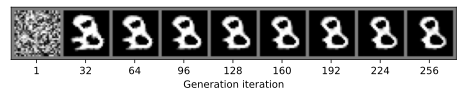

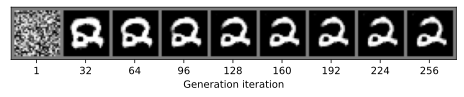

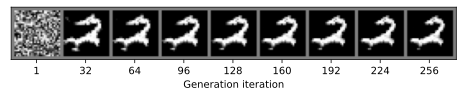

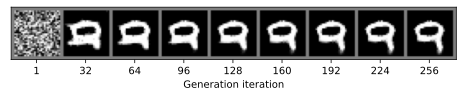

In [8]:
model.to(device)
pl.seed_everything(43)
callback = GenerateCallback(batch_size=4, vis_steps=8, num_steps=256)
imgs_per_step = callback.generate_imgs(model)
imgs_per_step = imgs_per_step.cpu()

for i in range(imgs_per_step.shape[1]):
    step_size = callback.num_steps // callback.vis_steps
    imgs_to_plot = imgs_per_step[step_size-1::step_size,i]
    imgs_to_plot = torch.cat([imgs_per_step[0:1,i],imgs_to_plot], dim=0)
    grid = torchvision.utils.make_grid(imgs_to_plot, nrow=imgs_to_plot.shape[0], normalize=True, value_range=(-1,1), pad_value=0.5, padding=2)
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(8,8))
    plt.imshow(grid)
    plt.xlabel("Generation iteration")
    plt.xticks([(imgs_per_step.shape[-1]+2)*(0.5+j) for j in range(callback.vis_steps+1)],
               labels=[1] + list(range(step_size,imgs_per_step.shape[0]+1,step_size)))
    plt.yticks([])
    plt.show()


## Self-Organazing Maps

**1. Overview**

A *Self-Organizing Map (SOM)*, also called a *Kohonen Map*, is a type of unsupervised learning algorithm used for *dimensionality reduction* and *clustering*. It maps high-dimensional input data onto a lower-dimensional (typically 2D) grid while preserving the topological structure.

**2. Notation**

- $ \mathbf{x} \in \mathbb{R}^n $ : Input data vector of dimension $ n $
- $ m_{i,j} \in \mathbb{R}^n $ : Weight vector associated with the neuron at position $ (i,j) $
- $ \mathcal{N} $ : Neighborhood function
- $ \eta(t) $ : Learning rate at iteration $ t $
- $ d(i,j) $ : Distance between neurons $ i $ and $ j $ on the grid



**3. SOM Training Algorithm**

The training process consists of four main steps, iterated over time:

*Step 1: Initialize Weights*
Each neuron $ (i, j) $ in the SOM grid has an associated weight vector $ m_{i,j} $ randomly initialized:
$$
m_{i,j}^{(0)} \sim U(0,1)
$$
where $ U(0,1) $ is a uniform distribution.


*Step 2: Select Input and Find Best Matching Unit (BMU)*
For each input sample $ \mathbf{x} $, find the Best Matching Unit (BMU), i.e., the neuron whose weight vector is closest to $ \mathbf{x} $:

$$
\text{BMU} = \arg \min_{i,j} \| \mathbf{x} - m_{i,j} \|
$$

where $ \| \cdot \| $ denotes the Euclidean norm.


*Step 3: Update Weights*

Adjust the weights of the *BMU* and its neighboring neurons using the update rule:

$$
m_{i,j}^{(t+1)} = m_{i,j}^{(t)} + \eta(t) \cdot \mathcal{N}_{i,j} \cdot (\mathbf{x} - m_{i,j}^{(t)})
$$

where:
- $ \eta(t) $ is the learning rate, which decays over time:  
  $$
  \eta(t) = \eta_0 e^{-t/\tau}
  $$
- $ \mathcal{N}_{i,j} $ is the *neighborhood function*, usually a Gaussian:

  $$
  \mathcal{N}_{i,j} = e^{-\frac{d^2(i,j)}{2\sigma^2(t)}}
  $$

  where $ \sigma(t) $ (neighborhood radius) also decreases over time:

  $$
  \sigma(t) = \sigma_0 e^{-t/\tau}
  $$



*Step 4: Repeat Until Convergence*
Repeat steps 2-3 for all training samples until the SOM grid stabilizes.


**4. Distance Metrics**

To determine the distance between neurons in the grid, we commonly use:
- *Euclidean Distance:*
  $$
  d(i,j) = \sqrt{(i_1 - j_1)^2 + (i_2 - j_2)^2}
  $$


**5. Convergence Criteria**

The training stops when:
1. The weight updates become *very small*:
   $$
   \| m_{i,j}^{(t+1)} - m_{i,j}^{(t)} \| < \epsilon
   $$
2. A *fixed number of iterations* is reached.


**6. Applications of SOMs**

- *Clustering*: Grouping similar data points
- *Dimensionality Reduction*: Mapping high-dimensional data to 2D
- *Visualization*: e.g., in Market Segmentation or Gene Expression Analysis
- *Feature Extraction*: Detecting patterns in data


**7. Summary**

- *SOMs use competitive learning* (only one neuron, the BMU, "wins" per iteration).
- *The weight update rule* ensures that nearby neurons in the grid evolve similarly, preserving the topology.
- *The neighborhood function* decreases over time, refining the map structure.

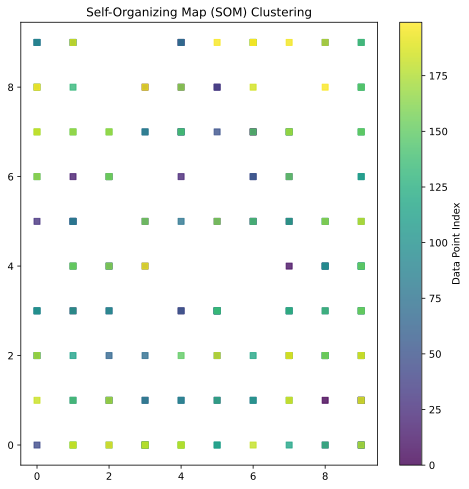

In [9]:
# pip install minisom

import numpy as np
import matplotlib.pyplot as plt
from minisom import MiniSom

# Generate some example data (e.g., random 2D points)
np.random.seed(42)
data = np.random.rand(200, 3)  # 200 samples, 3 features

# Define SOM grid size (10x10 neurons)
som_size = (10, 10)

# Initialize the SOM
som = MiniSom(x=som_size[0], y=som_size[1], input_len=3, sigma=1.0, learning_rate=0.5)

# Randomly initialize the weights
som.random_weights_init(data)

# Train the SOM with 1000 iterations
som.train_random(data, 1000)

# Get the winner neurons (BMUs) for each data point
bmu_positions = np.array([som.winner(d) for d in data])

# Plot the clustering results
plt.figure(figsize=(8, 8))
plt.scatter(bmu_positions[:, 0], bmu_positions[:, 1], c=np.arange(len(data)), cmap="viridis", marker="s", alpha=0.8)
plt.colorbar(label="Data Point Index")
plt.title("Self-Organizing Map (SOM) Clustering")
plt.show()
